In [1]:
import os
import cv2
import numpy as np
import random

from tqdm import tqdm
from utils import (
    overlay_image_with_blend, 
    gaussian_kernel, zip_folder)

from utils.algorithms import (
    perlin_noise, 
    generate_parallel_or_perpendicular_lines,
    generate_parallel_lines_adjacent)

[[(27, 253), (28, 253), (29, 253), (30, 253), (31, 253), (32, 253), (33, 253), (34, 253), (35, 253), (36, 253), (37, 253), (38, 253), (39, 253), (40, 253), (41, 253), (42, 253), (43, 253), (44, 253), (45, 253), (46, 253), (47, 253), (48, 253), (49, 253), (50, 253), (51, 253), (52, 253), (53, 253), (54, 253), (55, 253), (56, 253), (57, 253), (58, 253), (59, 253), (60, 253), (61, 253), (62, 253), (63, 253), (64, 253), (65, 253), (66, 254), (67, 254), (68, 254), (69, 254), (70, 254), (71, 254), (72, 254), (73, 254), (74, 254), (75, 254), (76, 254), (77, 254), (78, 254), (79, 254), (80, 254), (81, 254), (82, 254), (83, 254), (84, 254), (85, 254), (86, 254), (87, 254), (88, 254), (89, 254), (90, 254), (91, 254), (92, 254), (93, 254), (94, 254), (95, 254), (96, 254), (97, 254), (98, 254), (99, 254), (100, 254), (101, 254), (102, 254), (103, 254), (104, 254), (105, 254), (106, 254), (107, 254), (108, 254), (109, 254), (110, 254), (111, 254), (112, 254), (113, 254), (114, 254), (115, 254), (11

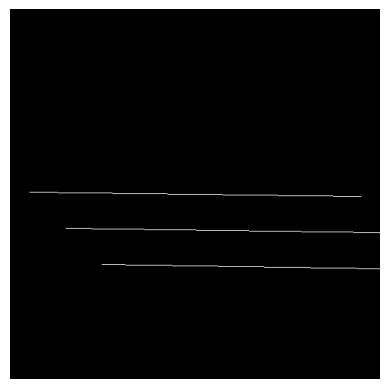

In [10]:
import matplotlib.pyplot as plt

def plot_lines(image_shape, lines):
    # Create a black image
    image = np.zeros(image_shape, dtype=np.uint8)

    # Draw white points on the image
    for line in lines:
        for point in line:
            x, y = point
            image[y, x] = 255

    # Display the image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

shape = (512,512)
lines = generate_parallel_lines_adjacent(shape)
print(lines)
plot_lines(shape, lines)

In [2]:
def entre(min_val, max_val, integer=False):
    """ Valor aleatorio entre [min_val, max_val] """
    if isinstance(min_val,int): return random.randint(min_val,max_val)
    if integer: return random.randint(int(min_val),int(max_val))
    return random.uniform(min_val,max_val)

def generate_images(shape_image_base=(512, 512), gaussian_size_low=4, gaussian_size_high=40, num_lines_range=(2, 6)):
    """
    Generate images with random parallel or perpendicular lines and apply Gaussian blur and Perlin noise.

    Parameters:
    shape_image_base (tuple): Base shape of the image (height, width).
    gaussian_size_low (int): Minimum size of the Gaussian kernel.
    gaussian_size_high (int): Maximum size of the Gaussian kernel.
    num_lines_range (tuple): Range for the number of lines to generate (min, max).

    Returns:
    tuple: Generated images (img, img_background, img_pretil_binary, img_pretil).
    """
    img = np.zeros(shape_image_base)
    img_tmp = np.zeros(shape_image_base)
    img_pretil = np.zeros(shape_image_base)
    img_pretil_binary = np.zeros(shape_image_base)

    # Generate between 2 and 6 parallel or perpendicular lines
    num_lines = np.random.randint(num_lines_range[0], num_lines_range[1] + 1)
    if np.random.rand() < 0.5:
        lines = generate_parallel_or_perpendicular_lines(shape_image_base, num_lines)
    else: 
        lines = generate_parallel_lines_adjacent(shape_image_base)


    # Overlay the lines on the image
    for line in lines:
        img_line = np.zeros(shape_image_base)
        random_size = entre(gaussian_size_low, gaussian_size_high, integer=True)
        for point in line:
            factor = entre(0.5,1)
            if int(random_size * factor) < 2:
                continue
            gaussian = gaussian_kernel(int(random_size * factor), normalize=True)
            img_line += overlay_image_with_blend(img_tmp, gaussian, position=point)
        img_line = img_line / np.max(img_line) * entre(0.5, 2.5)   
        img = np.maximum(img, img_line)
    
    img_pretil = img.copy()
    img_pretil_binary = np.where(img >= 0.1, 1, 0)
    img_background = 1 - img_pretil_binary  
    img_pretil = np.clip(img_pretil, -10, 10)
    noise = perlin_noise((512, 512, 1), octaves=(entre(0.01, 0.02), entre(0.02,0.04), entre(0.04,0.08), entre(0.08, 0.1), entre(0.1,0.2), entre(0.2,0.3), entre(0.3,1))) 
    img += noise
    img = np.clip(img, -10, 10)
    
    return img, img_background, img_pretil_binary, img_pretil

In [ ]:
num_images = 100
dataset_path = 'dataset_val'

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
else:
    raise FileExistsError(f'Folder {dataset_path} already exists. Please remove it before running this script.')

gsd = 0.1  # Ground Sampling Distance (m/px)
shape_image_base = (512, 512)
pretril_size_low = np.round(0.4 / gsd)
pretil_size_high = np.round(4 / gsd)

for idx in tqdm(range(num_images)):
    img, img_backgound, img_pretil_binary, img_pretil = generate_images(shape_image_base,pretril_size_low, pretil_size_high)
    img_backgound = (img_backgound * 255).astype(np.uint8)
    img_pretil_binary = (img_pretil_binary * 255).astype(np.uint8)
    img_pretil = img_pretil.astype(np.half) 
    img = img.astype(np.half)

    np.savez_compressed(f'{dataset_path}/img_{idx}.npz', img)
    cv2.imwrite(f'{dataset_path}/img_backgound_{idx}.png', img_backgound)
    cv2.imwrite(f'{dataset_path}/img_pretil_binary_{idx}.png', img_pretil_binary)
    np.savez_compressed(f'{dataset_path}/img_pretil_{idx}.npz', img_pretil)
    
    #cv2.imwrite(f'{dataset_path}/img_pretil_{idx}.png', img_pretil)

In [ ]:
zip_folder(dataset_path, f'{dataset_path}.zip')